# 04_CAM-Based
# 50 min

In [1]:
import numpy as np
import warnings 
warnings.filterwarnings("ignore")import tensorflow as tf
import cv2

# Display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

2022-02-17 22:02:35.512441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Configurable parameters

In [7]:
def infer_target_layer(model):
    """
    Search for the last convolutional layer to perform CAM-Based method, as stated
    in the original paper.
    Args:
        model (tf.keras.Model): tf.keras model to inspect
    Returns:
        str: Name of the target layer
    """
    for layer in reversed(model.layers):
        # Select closest 4D layer to the end of the network.
        if len(layer.output_shape) == 4:
            return layer.name

    raise ValueError(
        "Model does not seem to contain 4D layer. CAM-Based method cannot be applied."
    )

In [8]:
img_path = 'border-collie.jpg'
model_builder = tf.keras.applications.resnet50.ResNet50
img_size = (224, 224)
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions

In [9]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, layer_name=None, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    if layer_name is None:
        layer_name = infer_target_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## 1. Grad-CAM

## Let's test-drive it

2022-02-17 22:04:27.395697: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-17 22:04:27.396753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-17 22:04:27.585726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-02-17 22:04:27.588770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-02-17 22:04:27.591777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:0e:0

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02106166', 'Border_collie', 15.767093)]


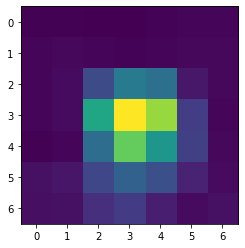

In [11]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model)

# Display heatmap
plt.imshow(heatmap)
plt.show()

## Create a superimposed visualization

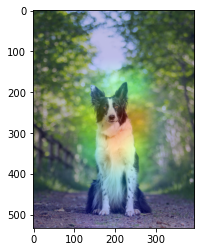

In [12]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.show()

display_gradcam(img_path, heatmap)

## Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's
try an image with a cat and a dog together, and see how the grad cam behaves.

In [13]:
img_path = 'cat_and_dog.jpg'

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

Predicted: [('n02123045', 'tabby', 7.8403497), ('n02129165', 'lion', 6.873202)]


We generate class activation heatmap for "chow," the class index is 260

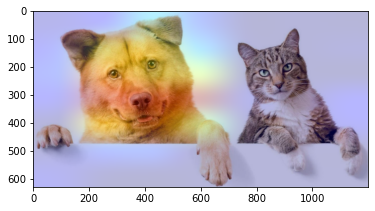

In [14]:
heatmap = make_gradcam_heatmap(img_array, model, pred_index=260)

display_gradcam(img_path, heatmap)

We generate class activation heatmap for "egyptian cat," the class index is 285

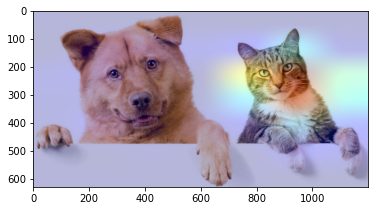

In [15]:
heatmap = make_gradcam_heatmap(img_array, model, pred_index=285)

display_gradcam(img_path, heatmap)

## 2. Layer-CAM

In [16]:
img_path = 'border-collie.jpg'

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

Predicted: [('n02106166', 'Border_collie', 15.767093), ('n02106030', 'collie', 13.498131)]


In [17]:
layer_names = ['conv5_block3_out', 'conv4_block6_out', 'conv3_block4_out']

In [18]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmaps = []
for layer_name in layer_names:
    heatmap = make_gradcam_heatmap(img_array, model, layer_name)
    print(heatmap.shape)
    heatmaps.append(heatmap)

Predicted: [('n02106166', 'Border_collie', 15.767093)]
(7, 7)
(14, 14)
(28, 28)


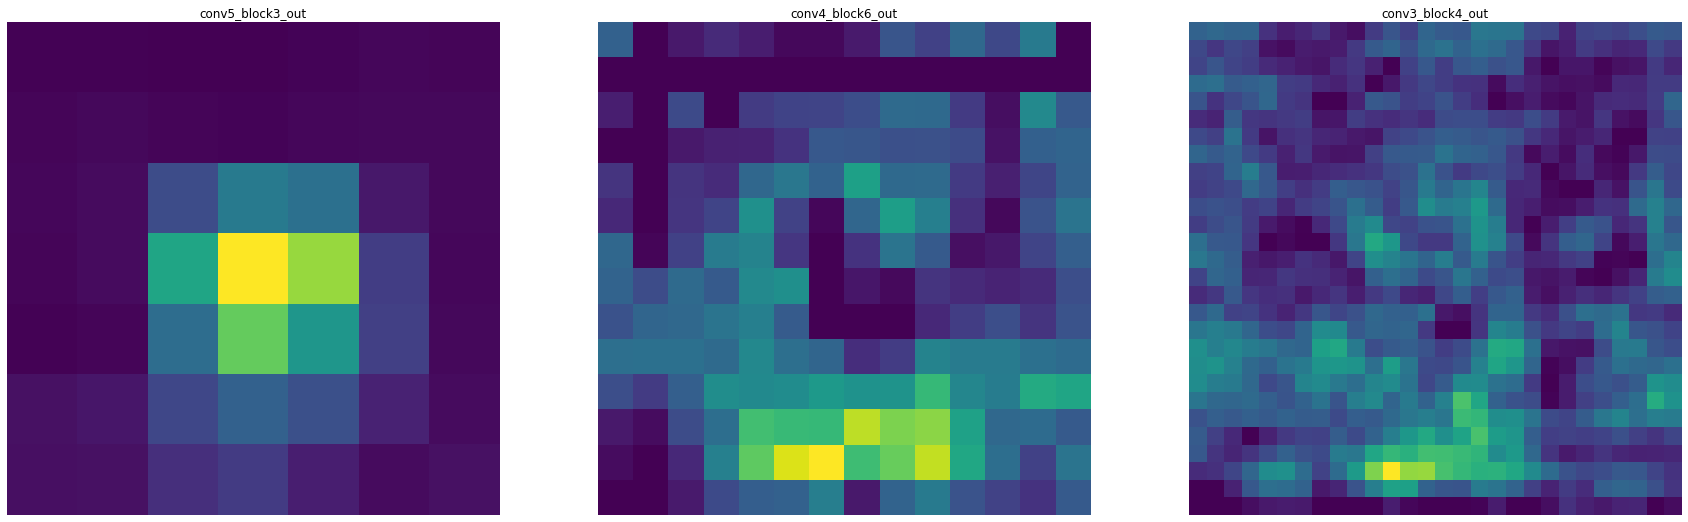

In [19]:
_, axes = plt.subplots(1, len(heatmaps), figsize=(30, 10))
for idx, name, hm in zip(range(len(heatmaps)), layer_names, heatmaps):
    axes[idx].imshow(hm); 
    axes[idx].axis('off');
    axes[idx].set_title(name);
plt.show()

In [20]:
hm_out = np.zeros((28, 28))
for hm in heatmaps:
    hm_out += cv2.resize(hm, (28, 28))
hm_out /= tf.math.reduce_max(hm_out)

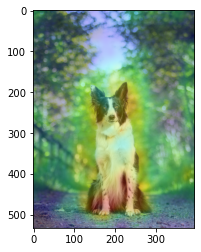

In [21]:
display_gradcam(img_path, hm_out)